# **INTRODUCTION**
This is the second part of my TTC Subway Delay project.

**Dataset**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import textwrap
import calendar

In [3]:
df_master = pd.read_excel('Excel Files/df_master.xlsx')
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean,line_clean,datetime,delay_cause,delay_category
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,Sheppard-Yonge,Lines 1 and 4 Shared,2024-01-01 02:00:00,Injured or ill Customer (On Train) - Transported,Passenger Related
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,Dundas,Line 1 Yonge-University,2024-01-01 02:00:00,Injured or ill Customer (In Station) - Transpo...,Passenger Related
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,Dundas,Line 1 Yonge-University,2024-01-01 02:08:00,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,Kennedy,Lines 2 and 3 Shared,2024-01-01 02:13:00,Debris At Track Level - Uncontrollable,Fortuitous Event
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,Bloor-Yonge,Lines 1 and 2 Shared,2024-01-01 02:22:00,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214456,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 19:50:00,Miscellaneous Other,Undefined
214457,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107,Warden,Line 2 Bloor-Danforth,2017-04-30 20:25:00,Disorderly Patron,Passenger Related
214458,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0,Keele,Line 2 Bloor-Danforth,2017-04-30 20:29:00,Robbery,Passenger Related
214459,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 22:00:00,Miscellaneous Other,Undefined


# **EXPLORATORY DATA ANALYSIS**

## Daily Delay Occurrences

Delay Occurrences is the count or number of recorded delays in a given time period.

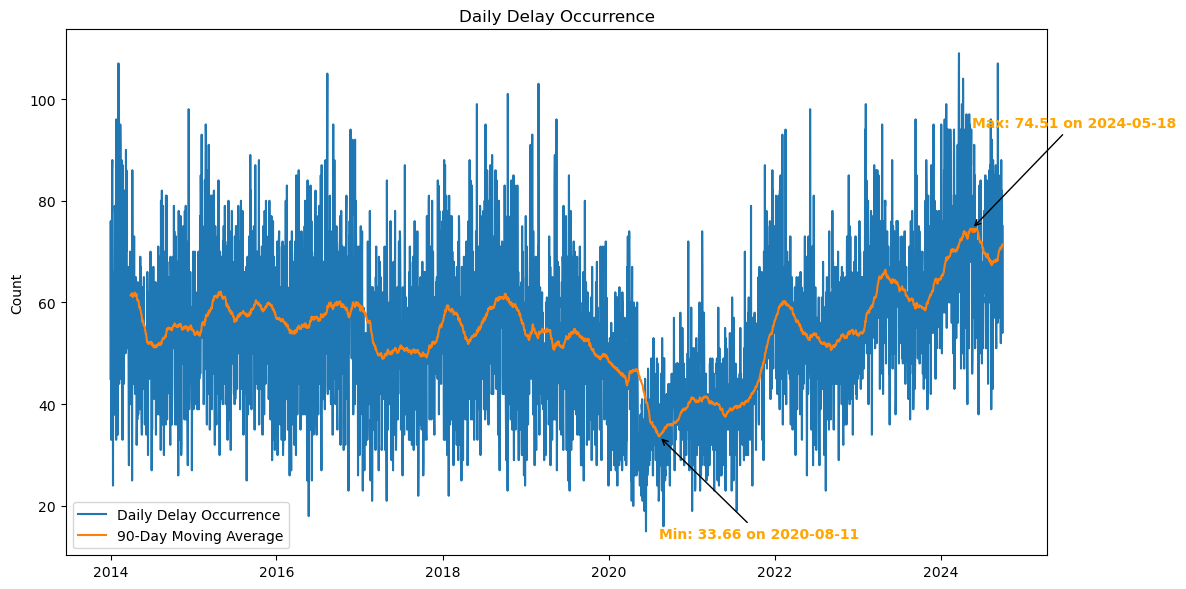

In [4]:
# group by date and count the delay occurrences
daily_delay_occurrence = df_master.groupby('Date')['Min Delay'].count().reset_index()
# compute the 90-day moving average
daily_delay_occurrence['MA90'] = daily_delay_occurrence['Min Delay'].rolling(window = 90).mean()

# create the line chart
plt.figure(figsize = (12,6))
plt.plot(daily_delay_occurrence['Date'], 
         daily_delay_occurrence['Min Delay'], 
         label = 'Daily Delay Occurrence')
plt.plot(daily_delay_occurrence['Date'], 
         daily_delay_occurrence['MA90'], 
         label = '90-Day Moving Average')
plt.title('Daily Delay Occurrence')
plt.ylabel('Count')

# annotate max values
max_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmax(), 'Date']
max_delay = daily_delay_occurrence['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), 
             xytext = (max_date, max_delay + 20),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

# annotate min values
min_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmin(), 'Date']
min_delay = daily_delay_occurrence['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), 
             xytext = (min_date, min_delay - 20),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

plt.legend()
plt.tight_layout()
plt.show()

The number of delays markedly decreased during the pandemic period, from the first quarter of 2020 to the end of 2021. Notably, post-pandemic averages saw an increasing trend, which mean that delays have been getting more frequent compared to pre-pandemic trends.

One important thing to note here, however, is that the dataset includes delay instances that lasted for less than a minute. The TTC marks these as delay occurrences even if they lasted for only several seconds, such as whenever the train has to slow its speed due to 'Miscellaneous' reasons. Therefore, the increasing occurrences might not necessarily mean that TTC's operations are getting worse.

The increasing trend post-pandemic in itself is inconclusive, as this may also indicate better recording practices by TTC from a data collection perspective.

## Daily Delay Duration

Delay Duration is the sum of the length (duration) of recorded delays, as recorded under the 'Min Delay' column of the data frame, in a given time period.

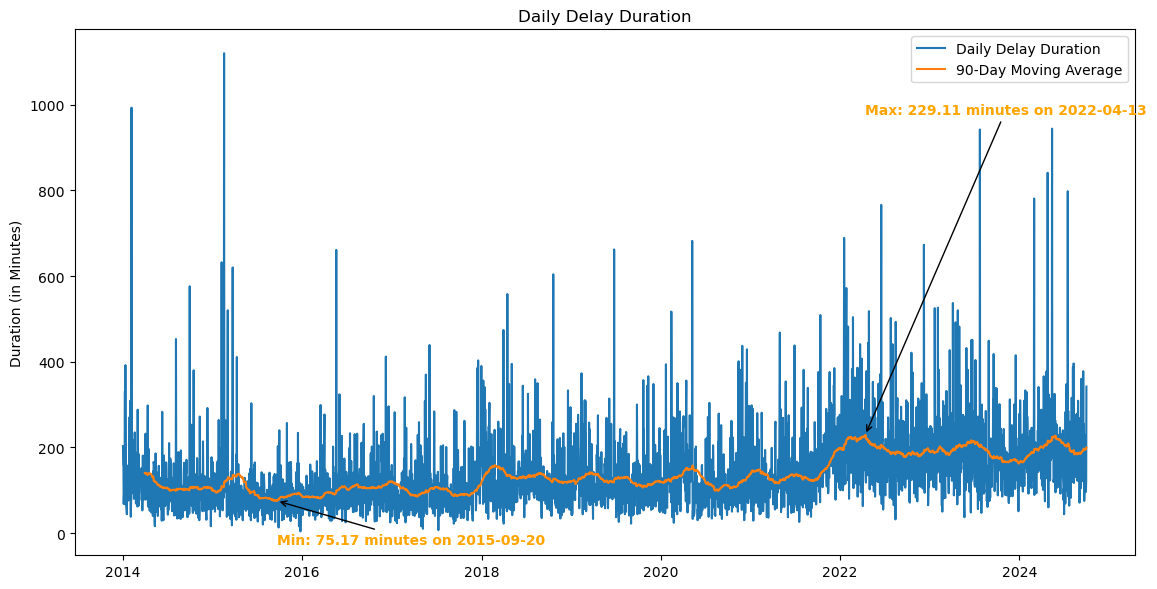

In [5]:
# group by date and sum the delay occurrences
daily_delay_duration = df_master.groupby('Date')['Min Delay'].sum().reset_index()
# compute the 90-day moving average
daily_delay_duration['MA90'] = daily_delay_duration['Min Delay'].rolling(window = 90).mean()

# create the line chart
plt.figure(figsize = (12,6))
plt.plot(daily_delay_duration['Date'], 
         daily_delay_duration['Min Delay'], 
         label = 'Daily Delay Duration')
plt.plot(daily_delay_duration['Date'], 
         daily_delay_duration['MA90'], 
         label = '90-Day Moving Average')
plt.title('Daily Delay Duration')
plt.ylabel('Duration (in Minutes)')

# annotate max values
max_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmax(), 'Date']
max_delay = daily_delay_duration['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} minutes on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), 
             xytext = (max_date, max_delay + 750),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

# annotate min values
min_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmin(), 'Date']
min_delay = daily_delay_duration['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} minutes on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), 
             xytext = (min_date, min_delay - 100),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

plt.legend()
plt.tight_layout()
plt.show()


We see a more conclusive observation here: total delays per day have been lasting longer.

An escalation in the 90-day Moving Average Delay Duration (MADD) was seen in late 2017, which plateaued from early 2018 to the first quarter of 2020. The beginning of the Covid-19 pandemic in the second quarter of 2020 reduced delay durations because of limited subway operations due to lockdowns. However, upon reopening of the economy sometime in late 2021, 90-day MADD began ascending and peaked on February 12, 2022 at 229.11 minutes (3.8 hours) on a single day. The 90-day MADD plateaued once more after this date, notably at a higher level compared to that during the pandemic and pre-pandemic periods.

## Time of Delay

Total of delay durations by minute.

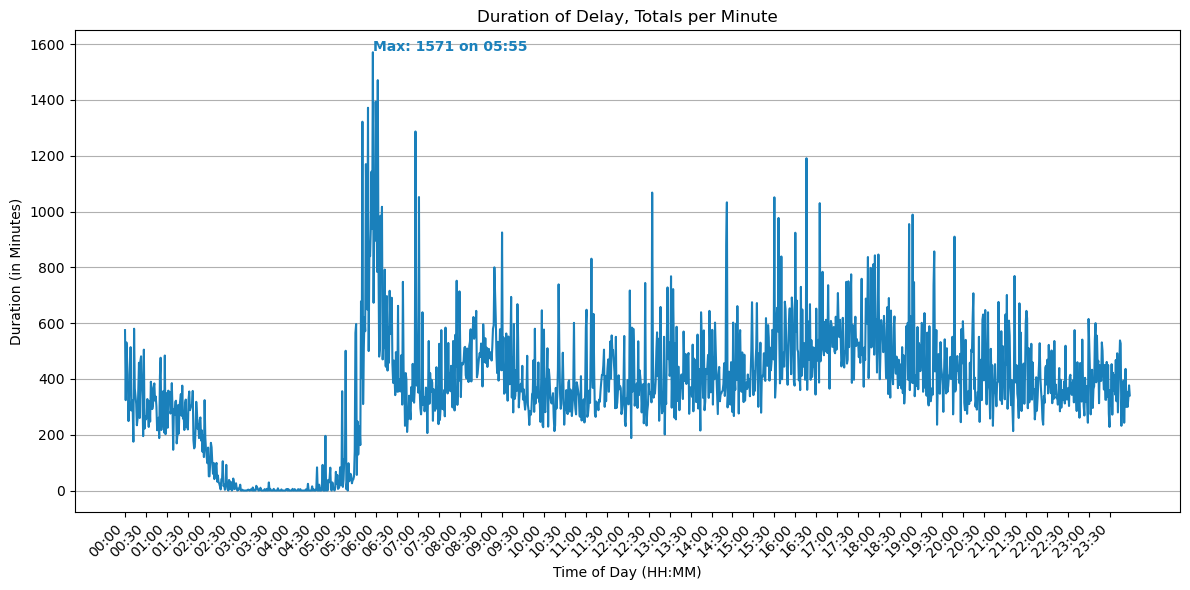

In [6]:
# group by time and sum the delay duration
delay_duration_per_minute = df_master.groupby('Time')['Min Delay'].sum().reset_index()

# create the line chart
plt.figure(figsize=(12, 6))
plt.plot(delay_duration_per_minute['Time'], 
         delay_duration_per_minute['Min Delay'], 
         color='#1a80bb')
plt.title('Duration of Delay, Totals per Minute')
plt.xlabel('Time of Day (HH:MM)')
plt.xticks(delay_duration_per_minute['Time'][::30], rotation=45, ha='right')
plt.ylabel('Duration (in Minutes)')
plt.grid(axis='y')

# maximum data annotation
max_time = delay_duration_per_minute.loc[delay_duration_per_minute['Min Delay'].idxmax(), 'Time']
max_delay = delay_duration_per_minute['Min Delay'].max()
plt.annotate(f'Max: {max_delay} on {max_time}',
             xy = (max_time, max_delay), 
             xytext = (max_time, max_delay + 5),
             fontsize = 10, 
             color = '#1a80bb', 
             fontweight = 'bold')

plt.tight_layout()
plt.show()

When delay durations are totaled per minute, 05:55 (5:55 am) had the longest delays. This is a critical time for TTC commuters as this may represent a time when people are on their way to their workplaces.

## Delay Causes

One of the primary objectives of this paper is to determine whether we can improve the efficiency and reliability of the TTC Subway System. As shown previously, there are 200 delay causes identified by the TTC in its excel file (they separated the delay causes between Lines 1, 2, and 4, and Line 3; a number of causes are identical between them), out of which 143 were present in the cleaned dataset. This poses a huge problem in our data analysis.

In [7]:
# group by delay_cause and create a table with count, sum, average, and delay_category
grouped_delay_causes = df_master.groupby('delay_cause').agg(
    total_occurrence = ('Min Delay', 'count'),
    delay_duration = ('Min Delay', 'sum'),
    delay_category = ('delay_category', 'first')).reset_index()
grouped_delay_causes['average_delay'] = grouped_delay_causes['delay_duration'] / grouped_delay_causes['total_occurrence']
grouped_delay_causes

,delay_cause,total_occurrence,delay_duration,delay_category,average_delay
0,ATC Operator Related,342,1467,Personnel Related,4.289474
1,ATC Project,3302,15434,Equipment Related,4.674137
2,ATC RC&S Equipment,124,644,Equipment Related,5.193548
3,ATC Signals Other,54,132,Equipment Related,2.444444
4,Air Conditioning,361,1518,Equipment Related,4.204986
...,...,...,...,...,...
138,Work Refusal,221,786,Personnel Related,3.556561
139,Work Vehicle,153,1993,Equipment Related,13.026144
140,Work Zone Problems - Signals,105,562,Equipment Related,5.352381
141,Work Zone Problems - Track,581,6020,Equipment Related,10.361446


In [8]:
# for a consistent color-scheme per category, we're creating a dictionary here
colors = {'Personnel Related': 'red',
          'Equipment Related': 'orange',
          'Passenger Related': 'green',
          'Fortuitous Event': 'purple',
          'Undefined': 'gray'}

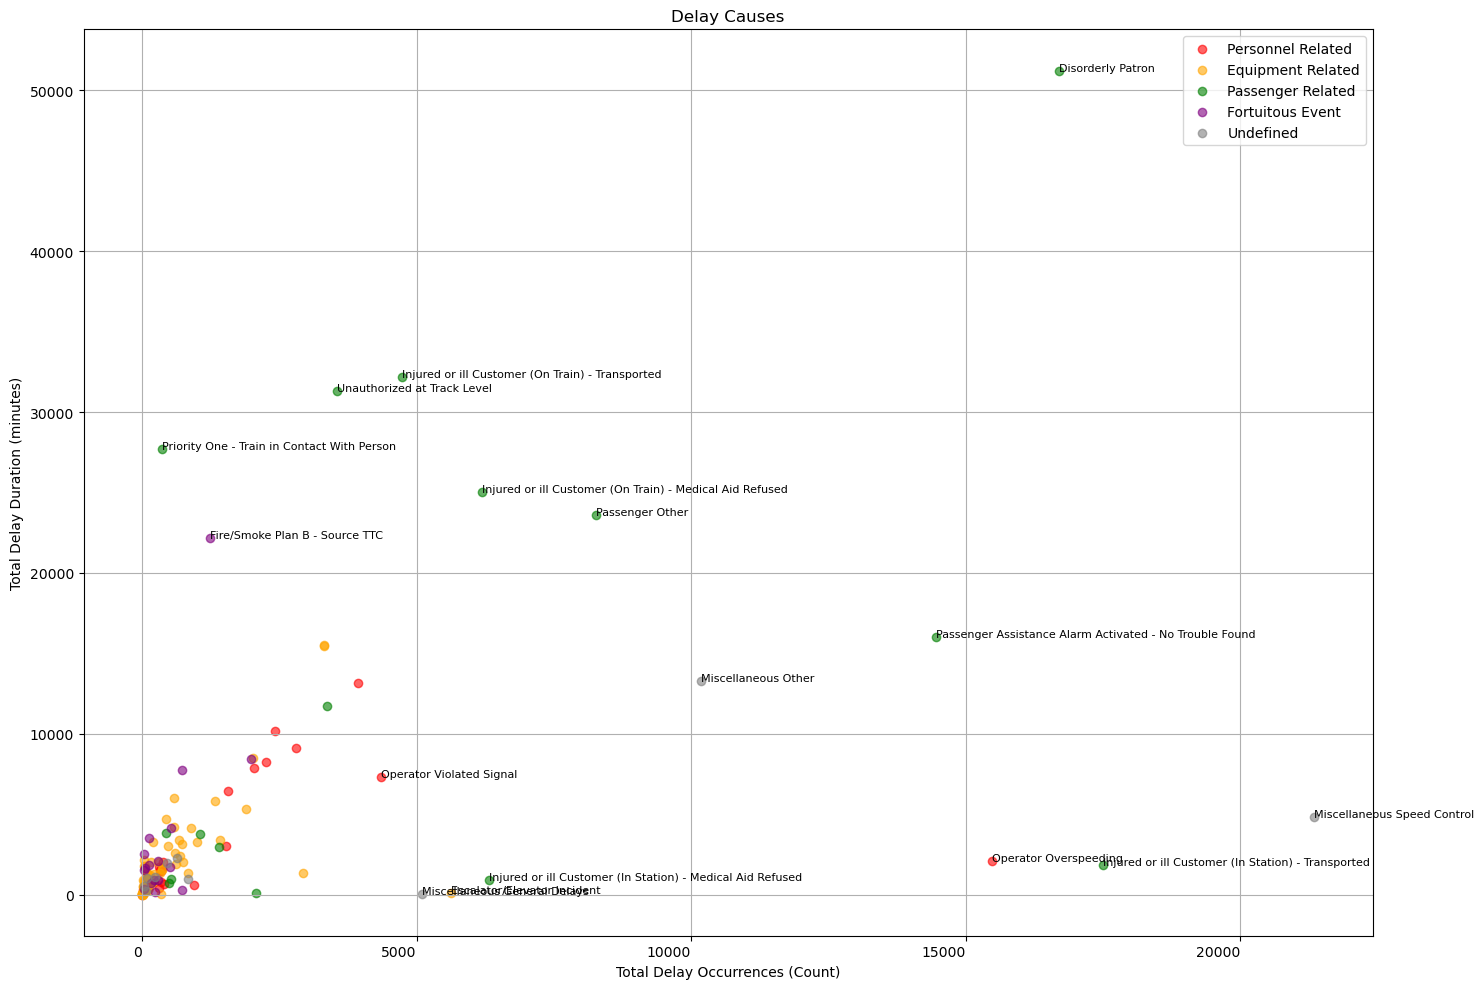

In [9]:
# create scatterplot per delay_cause and implement color scheme per delay_category
plt.figure(figsize = (15, 10))
for category, color in colors.items():
    subset = grouped_delay_causes[grouped_delay_causes['delay_category'] == category]
    plt.scatter(subset['total_occurrence'],
                subset['delay_duration'],
                #s = subset['average_delay'] * 10,
                alpha = 0.6,
                label = category,
                c = color)

# annotate data that meets criteria below
for i, row in grouped_delay_causes[
    (grouped_delay_causes['total_occurrence'] > 4000) |
    (grouped_delay_causes['delay_duration'] > 20000)].iterrows():
    plt.annotate(row['delay_cause'], 
                (row['total_occurrence'], row['delay_duration']), 
                fontsize = 8)

plt.title('Delay Causes')
plt.xlabel('Total Delay Occurrences (Count)')
plt.ylabel('Total Delay Duration (minutes)')
plt.xticks(rotation = 0, ha = 'right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Here we classify delays in terms of risk management:
1. Unlikely Bother, or Low-Likelihood Low-Severity delays
 - These are delay causes that are not frequent and also with low delay duration. They almost never happen and, if they do, have very little impact and can easily be rectified. In our scatterplot above, these are the delay causes that occupy the lower left quadrant (less than 20,000 minutes duration and less than 10,000 occurrences): 'Operator Violated Signal', 'Injured or ill Customer (in Station) - Medical Aid Refused', 'Escalator/Elevator Incident', etc. We can see from our plot above that majority of recorded delays fall within this classification.

2. Frequent Nuisance, or High-Likelihood Low-Severity delays
 - These are delay causes that are frequent but with low delay duration. These include minor equipment malfunctions that are resolved quickly, routine maintenance issues, etc. In our scatterplot above, these are the delay causes that occupy the lower right quadrant (less than 20,000 minutes duration and more than 10,000 occurrences): 'Miscellaneous Speed Control', 'Operator Overspeeding', 'Injured or ill Customer (In Station) - Transported', 'Passenger Assistance Alarm Activated - No Trouble Found', 'Miscellaneous Other', etc.

3. Black Swans, or Low-Likelihood High-Severity delays
 - In risk management, this is any event that is rare but with severe consequences. Delay causes that are low in terms of delay occurrence but high in delay duration (more than 20,000 minutes duration and less than 10,000 occurrences) are considered Black Swans: 'Injured or ill Customer (On Train) - Medical Aid Refused', 'Injured or ill Customer (On Train) - Transported', 'Unauthorized at Track Level', 'Priority One - Train in Contact with Person', etc.

4. Critical Risk, or High-Likelihood High-Severity delays
 - These are events that are high in both frequency and duration (more than 20,000 minutes duration and more than 10,000 occurrences). A single delay cause falls in this classification: 'Disorderly Patron'.



In [10]:
# group into delay category and per month
grouped_delay_category = df_master.groupby([
        df_master['delay_category'],
        df_master['datetime'].dt.to_period('M').dt.to_timestamp()
    ]).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
grouped_delay_category['average_delay'] = grouped_delay_category['delay_duration'] / grouped_delay_category['total_occurrence']
grouped_delay_category['3-Month MA'] = grouped_delay_category['delay_duration'].rolling(window = 3).mean()
grouped_delay_category

,delay_category,datetime,total_occurrence,delay_duration,average_delay,3-Month MA
0,Equipment Related,2014-01-01,372,1467,3.943548,NaN
1,Equipment Related,2014-02-01,293,1054,3.597270,NaN
2,Equipment Related,2014-03-01,347,1385,3.991354,1302.000000
3,Equipment Related,2014-04-01,287,1112,3.874564,1183.666667
4,Equipment Related,2014-05-01,292,992,3.397260,1163.000000
...,...,...,...,...,...,...
640,Undefined,2024-05-01,219,274,1.251142,238.333333
641,Undefined,2024-06-01,175,195,1.114286,227.000000
642,Undefined,2024-07-01,206,184,0.893204,217.666667
643,Undefined,2024-08-01,301,517,1.717608,298.666667


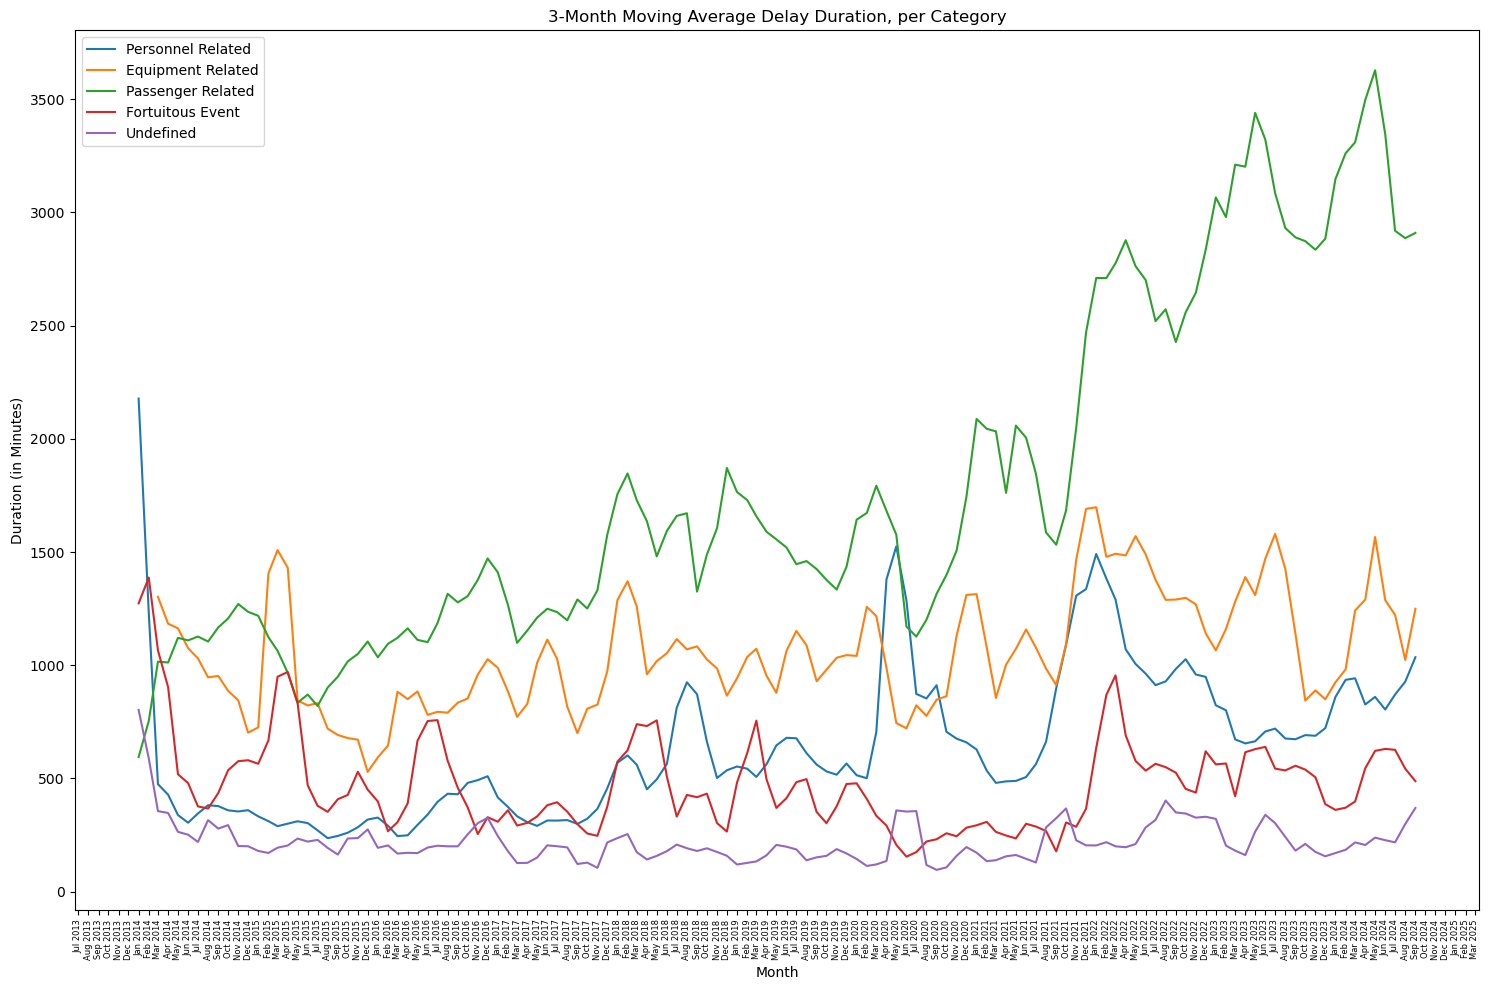

In [11]:
# plot in a line chart to look for trends per delay category using 3-month averages
plt.figure(figsize = (15,10))
for category, color in colors.items():
    subset = grouped_delay_category[grouped_delay_category['delay_category'] == category]
    plt.plot(subset['datetime'], 
             subset['3-Month MA'], 
             label = category)
    
plt.title('3-Month Moving Average Delay Duration, per Category')
plt.xlabel('Month')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation = 90, fontsize = 6)
plt.ylabel('Duration (in Minutes)')
plt.legend()
plt.tight_layout()
plt.show()

Four (4) categories led the initial spike in late 2021: Fortuitous Event, Personnel Related, Equipment Related, and Passenger Related. However, three (3) of the four (4) have since slowly tapered down, save for Passenger Related whose trend continues to worsen.

We can conclude from the above line chart that the worsening 90-day MADD since late 2021 was primarily caused by the worsening of the duration of Passenger-Related delays, as seen in the 3-month MADD above. 

## Passenger Related Category

In [12]:
# group by delay cause per month
grouped_passenger = df_master[df_master['delay_category'] == 'Passenger Related'].groupby([
        df_master['delay_cause'],
        df_master['datetime'].dt.to_period('M').dt.to_timestamp()
    ]).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')
    ).reset_index()
# compute average delay per cause
grouped_passenger['average_delay'] = grouped_passenger['delay_duration'] / grouped_passenger['total_occurrence']
# compute 3-month moving average per delay cause
grouped_passenger['3-Month MA'] = grouped_passenger['delay_duration'].rolling(window = 3).mean()
grouped_passenger

,delay_cause,datetime,total_occurrence,delay_duration,average_delay,3-Month MA
0,Assault / Employee Involved,2014-01-01,8,9,1.125000,NaN
1,Assault / Employee Involved,2014-02-01,5,6,1.200000,NaN
2,Assault / Employee Involved,2014-03-01,6,11,1.833333,8.666667
3,Assault / Employee Involved,2014-04-01,10,26,2.600000,14.333333
4,Assault / Employee Involved,2014-05-01,6,0,0.000000,12.333333
...,...,...,...,...,...,...
2014,Unauthorized at Track Level,2024-05-01,64,457,7.140625,545.666667
2015,Unauthorized at Track Level,2024-06-01,57,439,7.701754,522.666667
2016,Unauthorized at Track Level,2024-07-01,46,364,7.913043,420.000000
2017,Unauthorized at Track Level,2024-08-01,50,343,6.860000,382.000000


In [13]:
grouped_passenger_delay_cause = grouped_passenger.groupby('delay_cause').agg(
        total_occurrence = ('total_occurrence', 'sum'),
        delay_duration = ('delay_duration', 'sum')).reset_index()
grouped_passenger_delay_cause

,delay_cause,total_occurrence,delay_duration
0,Assault / Employee Involved,1401,2962
1,Assault / Patron Involved,3358,11714
2,Disorderly Patron,16704,51237
3,Door Problems - Passenger Related,1054,3775
4,Held By Polce - Non-TTC Related,431,3846
5,Injured or ill Customer (In Station) - Medical...,6321,918
6,Injured or ill Customer (In Station) - Transpo...,17496,1822
7,Injured or ill Customer (On Train) - Medical A...,6196,25031
8,Injured or ill Customer (On Train) - Transported,4735,32174
9,Passenger Assistance Alarm Activated - No Trou...,14462,15984


### Monthly Delay Duration, Passenger Related Delay Causes

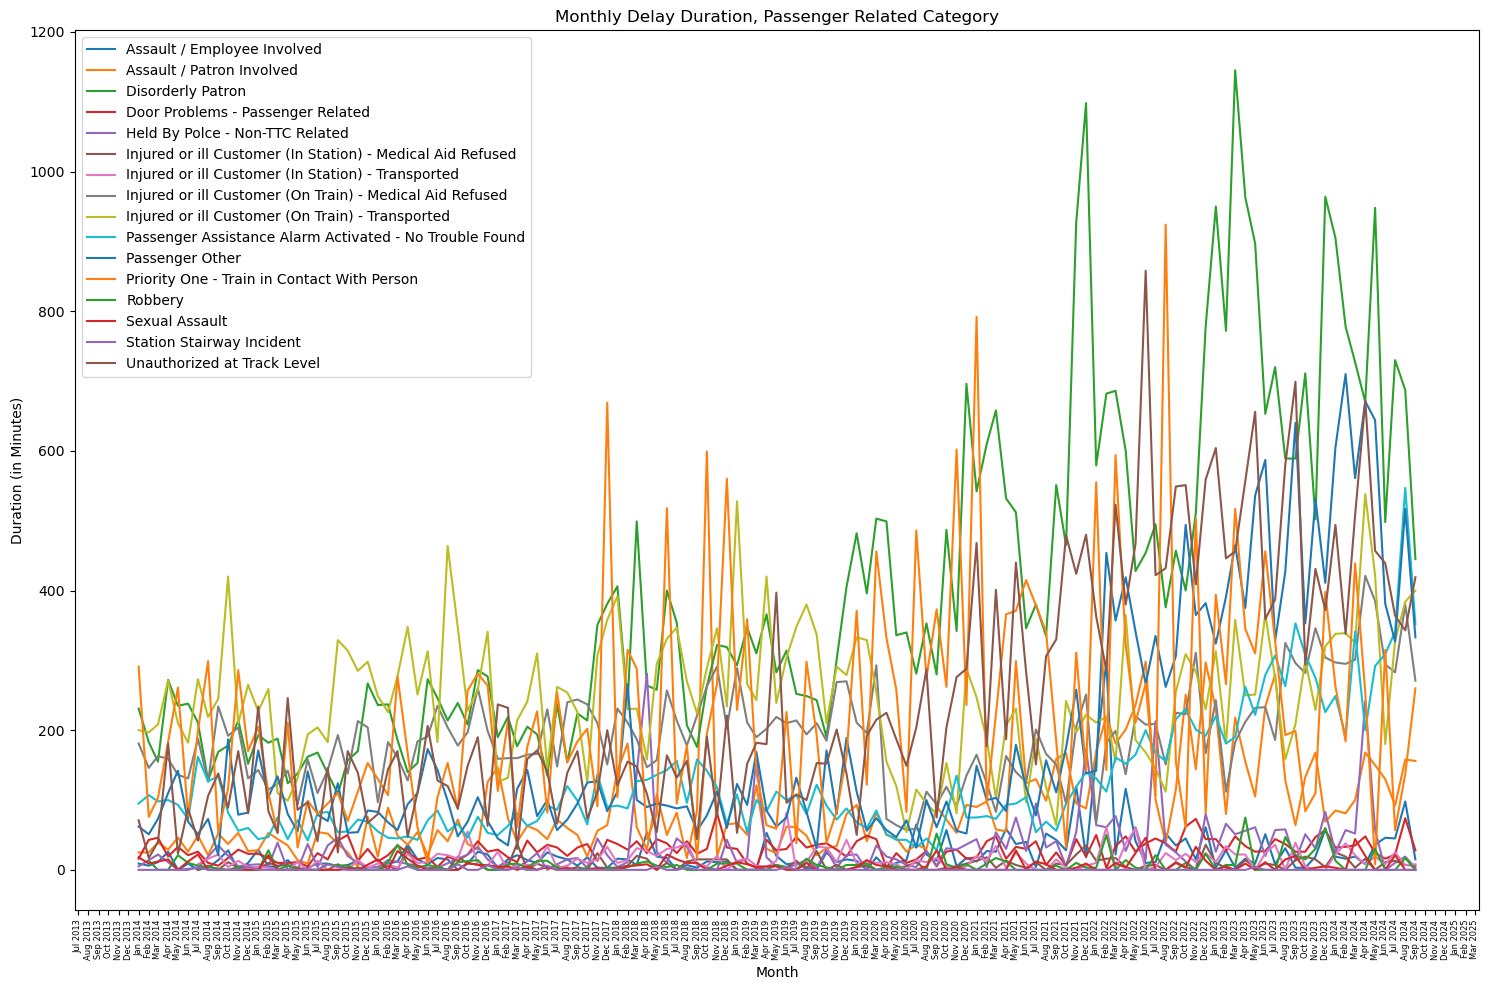

In [14]:
# plot in a line chart all the delay causes under Passenger Related category to see monthly trends
plt.figure(figsize = (15,10))
for cause in grouped_passenger['delay_cause'].unique():
    subset = grouped_passenger[grouped_passenger['delay_cause'] == cause]
    plt.plot(subset['datetime'],
             subset['delay_duration'],
             label = cause)
    
plt.title('Monthly Delay Duration, Passenger Related Category')
plt.xlabel('Month')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation = 90, fontsize = 6)
plt.ylabel('Duration (in Minutes)')
plt.legend()
plt.tight_layout()
plt.show()

There are 16 delay causes under the Passenger Related category. Visually, the above chart is extremely cluttered.

### Linear Regression on Delay Causes

Aside from visually assessing the trend of each delay cause, we can also mathematically check if the delay duration per delay cause is actually getting worse or better. We do this through linear regression. Here, we assign the month as the independent variable and the delay duration as the dependent variable.

In [15]:
# create a new column to convert datetime column from datetime data type to numeric data type
grouped_passenger['datetime_numeric'] = grouped_passenger['datetime'].apply(lambda x: x.timestamp())

# perform linear regression
results_passenger = []
for cause in grouped_passenger['delay_cause'].unique():
    subset = grouped_passenger[grouped_passenger['delay_cause'] == cause]
    slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
    results_passenger.append({'delay_cause': cause, 'slope': slope, 'p-value': p_value})

A positive slope indicates that the delay duration is getting worse. A negative slope indicates that it is getting better.
A p-value of less than 0.05 means that the change (i.e. the slope, whether positive or negative) is statistically significant. A p-value of equal or more than 0.05 means that the delay duration is getting worse due to random chance.

In [16]:
results_passenger

[{'delay_cause': 'Assault / Employee Involved',
  'slope': 1.1534020628866472e-07,
  'p-value': 0.0001632704200499845},
 {'delay_cause': 'Assault / Patron Involved',
  'slope': 4.1091712354784913e-07,
  'p-value': 1.2842371835442596e-09},
 {'delay_cause': 'Disorderly Patron',
  'slope': 1.9489964999304936e-06,
  'p-value': 6.995477680417681e-31},
 {'delay_cause': 'Door Problems - Passenger Related',
  'slope': 4.861555598165666e-08,
  'p-value': 0.00020417461341988498},
 {'delay_cause': 'Held By Polce - Non-TTC Related',
  'slope': 1.45434642691248e-07,
  'p-value': 0.0006317027487379573},
 {'delay_cause': 'Injured or ill Customer (In Station) - Medical Aid Refused',
  'slope': 1.9208284628312206e-08,
  'p-value': 0.015697471242994348},
 {'delay_cause': 'Injured or ill Customer (In Station) - Transported',
  'slope': 2.30654070894182e-08,
  'p-value': 0.09681723093845082},
 {'delay_cause': 'Injured or ill Customer (On Train) - Medical Aid Refused',
  'slope': 2.8376493361990286e-07,
  